In [6]:
from openmm.app import AmberPrmtopFile
import numpy as np
import mdtraj
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from scipy.stats import linregress

### Define classical calculations

In [7]:
def get_angle(vector_1,vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def get_unit(vector):
    return vector / np.expand_dims(np.linalg.norm(vector,axis=1),1)

def calculate_kappa_dis_dipole_for_frame(xyz,charges,c6_idx,c10_idx):
    copper_dis = cdist(xyz,np.expand_dims(xyz[-1,:],0)).T[0]
    copper_vec = xyz - np.expand_dims(xyz[-1,:],0)
    charges = charges[:-1]
    copper_dis = copper_dis[:-1]
    copper_vec = copper_vec[:-1,:]
    dipole = get_unit(copper_vec) * np.expand_dims(charges / (copper_dis**2),1)
    pol_alpha = 0.148 * 3.09471 # angstrom ** 3
    induced_dipol = np.sum(dipole,0) * -1 * pol_alpha / 0.529 # in atomic units.
    dye_dipole = xyz[c6_idx] - xyz[c10_idx]
    copperC6vec = xyz[c6_idx] - xyz[-1]
    theta = get_angle(induced_dipol,dye_dipole)
    alpha = get_angle(copperC6vec,induced_dipol)
    delta = get_angle(copperC6vec,dye_dipole)
    kappa = (np.cos(theta) - 3*np.cos(delta)*np.cos(alpha))**2
    return kappa , copper_dis[c6_idx], induced_dipol

In [8]:
import openmm.unit as unit
import numpy as np

In [9]:
epsilon = 8.8541878128 * 10**-12 * unit.ampere * unit.second / unit.volt / unit.meter
alpha = 0.12 * 10e-24*unit.centimeter**3 * epsilon * 4 * np.pi

c = 0.5
r = 4
val = c*unit.elementary_charge/(r*unit.angstrom)**2 / (4*np.pi* epsilon)

alpha * val

Quantity(value=3.75e-10, unit=centimeter*elementary charge)

## Generate ADF input for reference calculations

In [10]:
def create_adf_in(adf_input_array,filename):
    filetxt = '''#!/bin/sh

    $AMSBIN/ams -n 8 <<eor
    
    Task SinglePoint

    System
        Atoms
   '''

    filetxt += 'Cu  %s %s %s' % (adf_input_array[-1,0],adf_input_array[-1,1],adf_input_array[-1,2])

    filetxt += '''
        End
        Charge 2
        ElectrostaticEmbedding
        MultipolePotential
            Coordinates
    '''

    for i in adf_input_array[:-1]:
      for t in i:
         filetxt += t + "\t"
      filetxt += "\n"

    filetxt += '''
      End
      End
      End
      End

      Engine ADF
         Basis
            Type QZ4P
         End

         XC
            hybrid B3LYP
         End

      QTAIM
      End
      EndEngine
eor
    '''

    with open(filename, 'w') as f:
      f.write(filetxt)

### Calculate Classically

#### Extract charges

####  Copy topologies and starting coordinates

In [12]:
# Calculate for L13 linker
top = AmberPrmtopFile('../Simulation/topologies_and_starting_coordinates/K_Dye2_plus_helix_cu.top')
system = top.createSystem()
nonbonded_force = system.getForces()[3]
charges = np.array([nonbonded_force.getParticleParameters(i)[0]._value for i in range(nonbonded_force.getNumParticles())])

#### read in trajectory

In [13]:
traj = mdtraj.load_hdf5('trajectories/plus100ns_start_water_300K_1to025_id3_r0_q1_rep0_4_output.h5')

In [14]:
dipoles = []
names = []
np.random.seed(161311)
for f in range(100):
    frame = np.random.randint(0,len(traj))
    xyz = traj[frame].xyz[0]

    _,_,dipole = calculate_kappa_dis_dipole_for_frame(xyz*10,charges,11,14)
    dipoles.append(dipole)
    # CONVERTS TO ANGSTROM
    adf_input_array = np.concatenate((xyz*10,np.expand_dims(np.array(charges,dtype='str'),axis=1)),axis=1)

    # Generate runfile
    create_adf_in(adf_input_array,'ADF_input/qcvsclassical_frame_%i.run' % frame)
    names.append('qcvsclassical_frame_%i.run' % frame)
    
    # Execute (ADF must be installed)
    # os.system('bash qcvsclassical.run > qcvsclassical.out')
    # os.system('grep -A 4 \'dip-x\' qcvsclassical.out')
    # 
    # grep -A 2 'dip-x' result.txt | tail -1 | awk '{print $4,$5,$6}' >> newresults.txt

In [16]:
# read in results
adf_dipoles = pd.read_table('ADF_results/new_results.txt',header=None,sep=' ').values

# results are sorted based on name of the infile according to ls
adf_in_sort = pd.read_table('ADF_results/order.txt',header=None).values
adf_in_sort = [s[0] for s in adf_in_sort if '.run' in s[0]]

In [17]:
pair_x = np.empty((100,3))
pair_y = np.empty((100,3))
for id in range(100):
    pair_x[id] = adf_dipoles[np.where([adf_in_sort[i] == names[id] for i in range(100)])[0][0]]
    pair_y[id] = dipoles[id]


0.0015139737822849734


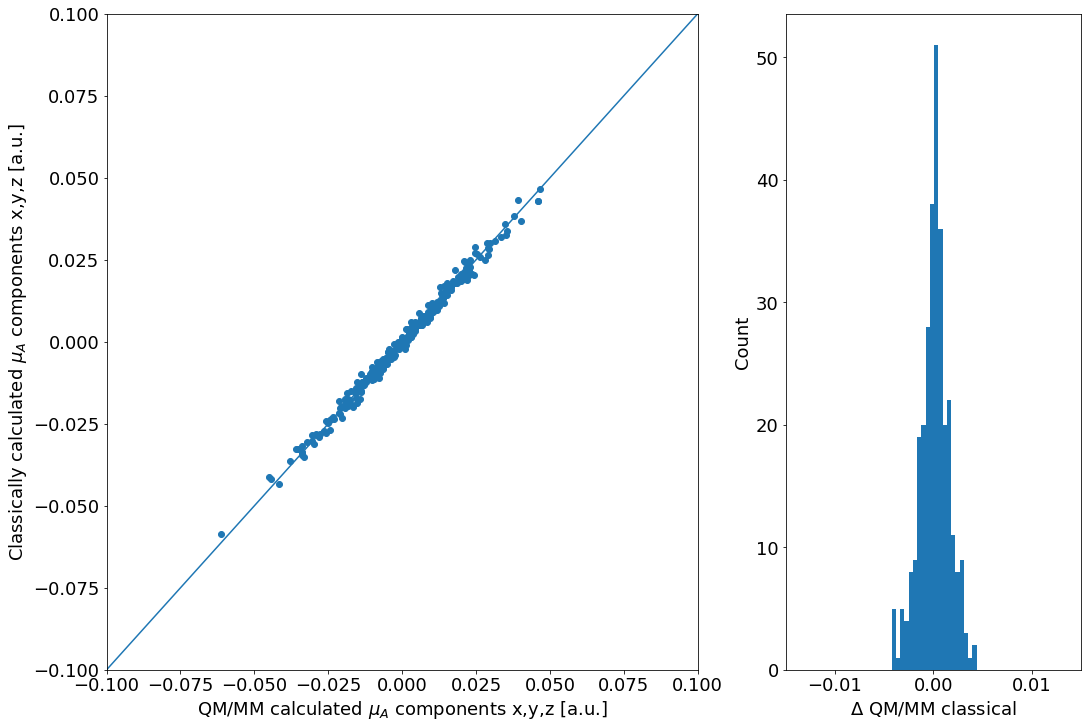

In [19]:


xs = pair_x
ys = pair_y
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 18})
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    [
        ["trupre",'hist']
    ],
    empty_sentinel="BLANK",
    gridspec_kw={"width_ratios":[2,1]}
)

axd['trupre'].scatter(xs,ys)
_ = axd['hist'].hist(np.abs(xs.reshape((100*3)))-np.abs(ys.reshape((100*3))),log=False,bins=20)
#_ = axd['hist'].hist(xs.reshape((100*3))-ys.reshape((100*3)),log=False,bins=20)
axd['hist'].set_xlabel(r'$\Delta$ QM/MM classical')
axd['hist'].set_ylabel(r'Count')
axd['trupre'].plot([-1,1],[-1,1],zorder=1)
axd['trupre'].set_xlim([-0.1,0.1])
axd['trupre'].set_ylim([-0.1,0.1])
axd['hist'].set_xlim([-0.015,0.015])
axd['trupre'].set_xlabel(r'QM/MM calculated $\mu_A$ components x,y,z [a.u.]')
axd['trupre'].set_ylabel(r'Classically calculated $\mu_A$ components x,y,z [a.u.]')
print(np.sqrt(np.mean((xs-ys)**2)))
plt.savefig('Visualisations/QMvsCl.pdf')

### Calculate $R^2$

In [20]:
slope, intercept, r_value, p_value, std_err = linregress(pair_x.reshape(300),pair_y.reshape(300))

In [21]:
intercept, slope, r_value, p_value, std_err

(2.0718547061165113e-05,
 0.9858628384640266,
 0.9962818015594758,
 2.39157e-319,
 0.004938594552487034)